In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# 转换为独热编码
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# 设置显示样式的参数
# http://seaborn.pydata.org/generated/seaborn.set.html
sns.set(style='white', context='notebook', palette='deep')

In [14]:
# import warnings
# warnings.filterwarnings('ignore')

In [15]:
# 加载数据
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

(42000,)
(42000, 784)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

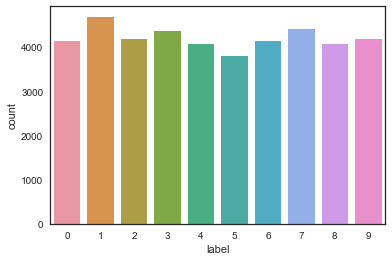

In [16]:
# 'label'
Y_train = train["label"]
print(Y_train.shape)

# 删除 'label' 列
X_train = train.drop(labels = ["label"],axis = 1) 
print(X_train.shape)

# 释放一些空间
del train

# 使用条形图显示每个分类数据集合中的观测值
# https://seaborn.pydata.org/generated/seaborn.countplot.html?highlight=countplot
g = sns.countplot(Y_train)

# 对训练集中的元素计数
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html
Y_train.value_counts()

In [17]:
# 检查数据
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [18]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [19]:
# 对数据进行归一化，到[0, 1]范围内，减小光照的影响，并可加速CNN收敛速度
X_train = X_train / 255.0
test = test / 255.0

In [20]:
# Reshape三维图像(height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [21]:
# 将标签编码为一个独热向量 (例如: 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [22]:
# 设置随机种子
random_seed = 2

# 分割出训练集和验证集
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

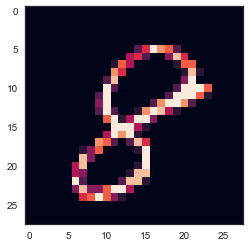

In [23]:
# 一些例子
g = plt.imshow(X_train[0][:,:,0])

In [24]:
# 设置CNN模型
model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

# 输出模型各层的参数状况
# model.summary()

In [25]:
# 用adam优化器和交叉熵损失进行编译
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 用sgd优化器
# model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

# 定义优化器
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# 编译模型
# model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [26]:
# 设置一个学习率衰减
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
# 训练轮数，暂时设置为1，可以自己尝试调整
epochs = 1
# epochs = 30 时可以99.5%
# 批大小
batch_size = 86

In [28]:
# 增加数据以防止过拟合
datagen = ImageDataGenerator(
        featurewise_center=False,  				# 在数据集上将输入平均值设置为0
        samplewise_center=False,  				# 将每个样本的平均值设置为0
        featurewise_std_normalization=False,    # 将输入除以数据集的std
        samplewise_std_normalization=False,  	# 将每个输入除以它的std
        zca_whitening=False,  					# 使用ZCA白化
        rotation_range=10,  					# 在范围内随机旋转图像（0到180度）
        zoom_range = 0.1, 						# 随机缩放图像
        width_shift_range=0.1,  				# 水平随机移动图像（总宽度的一部分）
        height_shift_range=0.1,  				# 垂直随机移动图像（总高度的一部分）
        horizontal_flip=False,  				# 随机翻转图像
        vertical_flip=False)  					# 随机翻转图像


datagen.fit(X_train)

In [29]:
# 拟合模型
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 263s - loss: 0.5130 - accuracy: 0.8423 - val_loss: 0.5066 - val_accuracy: 0.8340


C:\Users\Administrat\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


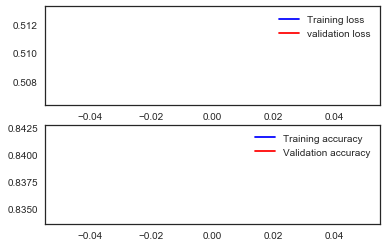

In [30]:
# 绘制训练和验证的损失和精度曲线
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

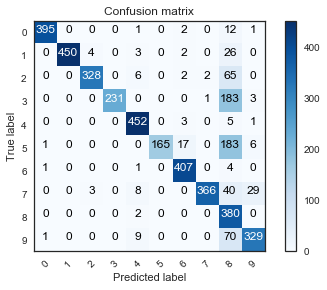

In [31]:
# 看混淆矩阵
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    此函数打印并绘制混淆矩阵
	可以通过设置 “normalize=true” 应用归一化
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 从验证数据集中预测值
Y_pred = model.predict(X_val)
# 将预测类转换为一个独热向量
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# 将验证观测转换为一个独热向量
Y_true = np.argmax(Y_val,axis = 1) 
# 计算混淆矩阵
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

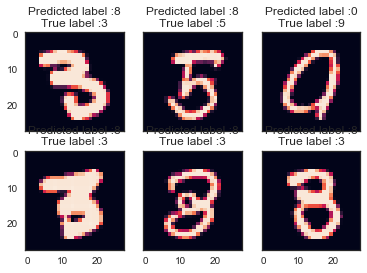

In [32]:
# 显示一些错误结果

# 错误是预测标签和真实标签之间的区别
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """
    此函数显示6个图像及其预测和实际标签
    """
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# 错误预测数的概率
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# 误差集中真值的预测概率
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# 预测标签概率与真实标签概率之差
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# 对预测标签概率与真实标签概率之差的列表进行排序
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6错误
most_important_errors = sorted_dela_errors[-6:]

# 展示Top 6错误
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [33]:
# 预测结果
results = model.predict(test)

# 选择最大概率的整数
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [34]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

# 转换成CSV格式，不保留索引
submission.to_csv("cnn_mnist_datagen.csv",index=False)